# Transformation equivariance loss

## Motivation

**Transformation equivariance (TE)** loss is a constraint that can be applied to learning pixel-level labels such as segmentation, keypoint localization or parts detection. 
TE constraint ensures that the output of the model changes the same way as the input.

For example, if the input image is rotated by 25 degrees then it is logical to expect that the output segmentation map should change consistently:

![Transformation equivariance idea](images/tf_equivariance_idea.png)


> Important: In case of supervised training (ground truth annotations are available for the whole training set), the model attains transformation equivariance via data augmentation. 
TE loss is useful in unsupervised or self-supervised settings (without ground truth labels). 

## In words

For the clarity of the discussion, we narrow down to the object segmentation task. The same approach applies to instance segmentation and keypoint localization. 

Transformation consistency means that when an image changes under transformations, the corresponding pixel-based label should change the same way. 

So if model outputs a segmentation mask or heatmaps for an image. If we transform the image, the output should change the same way. 

We talk only about transformation in space and not color transformations. Color perturbations does not change detected objects in space. 





![Transformation equivariance loss](images/tf_equivariance.png)

## In formula

Let us denote $F$ - the model, $T$ – transformation, $x$ – input image, $D$ - error function in the image space. 

Function $D$ depends on the application and can be a mean squared error or a [perceptual loss](https://deepai.org/machine-learning-glossary-and-terms/perceptual-loss-function).

**Transformation Equivariance (TE)** loss is formulated as follows: 

$$
L_{TE}(x) = D\big(F(T(x)) - T(F(x))\big)
$$

> Important: The assumption here is that the spatial dimensions (heights and width) of input images and output (e.g., segmentation maps or heatmaps) are the same. However, in practice output of models is smaller than the input because it reduces the number of parameters.
Our implementation resizes (with bilinear interpolation) the output of the model to match the image size before the loss computation. 

NOTE ON INVERSE TRANSFORM 

We argue that applying transformation T is better than using inverse transformation T^-1. Because transformation can make some parts of the object move from the boundaries of the image and inverse transformation wont’ bring it back. 

IMAGE TO SUPPORT NOT USING INVERSE TRANSFORM 

## Differentiable transformations

TE loss requires the ability to **backpropagate through the transformation**. 
While image transformations are provided in many augmentation pipelines such as [Pytorch Torchvision transforms](https://pytorch.org/vision/stable/transforms.html), [Keras image data preprocessing](https://keras.io/api/preprocessing/image/), [imgaug](https://github.com/aleju/imgaug) and [OpenCV](https://opencv.org/), these transformations do not support differentiation. 

Fortunately, a new library [**Kornia**](https://kornia.readthedocs.io/en/latest/index.html) comes to the resque to implement differentiable image transformations.
Kornia replicates OpenCV functions on tensors and allows differentiation. 

> -- <cite>Inspired by OpenCV, this library is composed by a subset of packages containing operators that can be inserted within neural networks to train models to perform image transformations, ... that operate directly on tensors. </cite>

Now let's see how TE loss is computed on three examples.

# Example 1: Dummy data on 1-layer CNN model
The first example is on dummy data and 1-layer convolutional model.

In [2]:
from tf_equivariance_loss import TfEquivarianceLoss
import torch
import torch.nn as nn

Get random dummy data:

In [3]:
x = torch.randn((4, 3, 64, 64))

The demo model is a one layer model with three convolutional 1x1 filters (no bias) which is just a weighted combination of RGB layers of a colour image. 
The model satisfies transformation equivariance constraint just by its design.
Let us check that the loss is zero.

In [4]:
model = nn.Sequential(nn.Conv2d(3, 1, 1, bias=False))
model

Sequential(
  (0): Conv2d(3, 1, kernel_size=(1, 1), stride=(1, 1), bias=False)
)

Initialise Transformation Equivariance loss. This example implements rotation transformation $T$ with a mean squared error as the function $D$.

In [5]:
tf_equiv_loss = TfEquivarianceLoss(
    transform_type='rotation',
    consistency_type='mse',
    batch_size=4,
    max_angle=90,
    input_hw=(64, 64)
)

Compute loss on a batch of data $x$:

In [7]:
# Generate a transformation
tf_equiv_loss.set_tf_matrices()

# Compute model on input image
fx = model(x)

# Transform output
tfx = tf_equiv_loss.transform(fx)

# Transform input image
tx = tf_equiv_loss.transform(x)

# Compute model on the transformed image
ftx = model(tx)

loss = tf_equiv_loss(tfx, ftx)
loss

tensor(6.8236e-16, grad_fn=<MseLossBackward>)

The computed loss is close to zero as expected for this kind of model.

# Example 2: Real data on 1-layer CNN model

Second example uses images from a subset of [Pascal VOC](http://host.robots.ox.ac.uk/pascal/VOC/) dataset (we select the smallest subset for demonstration purposes).

Data preparation in this example is a bit longer than for dummy data. Images are resized, converted to tensors and normalized. Segmentation maps are available for this dataset but they are not used for loss computations in our example (we still need to preprocess them to get torch tensors for data loader).

In [8]:
from torchvision.datasets import VOCSegmentation

In [22]:
import torchvision.transforms as T
image_tf = T.Compose([
    T.Resize((256, 256)),
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225]
               )
])

segm_tf = T.Compose([
    T.Resize((256, 256)),
    T.ToTensor()
])

In [23]:
# Load the smallest subset of VOC segmentation dataset
dataset = VOCSegmentation(
    root='../',
    year='2007',
    image_set='test',
    download=True,
    transform=image_tf, 
    target_transform=segm_tf,
    transforms=None,
    )

Using downloaded and verified file: ../VOCtest_06-Nov-2007.tar


In [24]:
# Define data loaders
data_loader = torch.utils.data.DataLoader(
    dataset, 
    batch_size=4, 
    shuffle=True, 
    num_workers=4,
)
data_loader_iter = iter(data_loader)

In [25]:
# Initialize model and train on the GPU or on the CPU, if a GPU is not available
model = nn.Sequential(nn.Conv2d(3, 1, 1, bias=False))
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)

Sequential(
  (0): Conv2d(3, 1, kernel_size=(1, 1), stride=(1, 1), bias=False)
)

In [26]:
# Get one batch and compute loss
data_batch = next(data_loader_iter)
# Take only images and discard annotations
x = data_batch[0]

Note that we are not using ground truth annotation for computing loss in this example

In [27]:
# Define loss
tf_equiv_loss = TfEquivarianceLoss(
    transform_type='rotation',
    consistency_type='mse',
    batch_size=4,
    max_angle=90,
    input_hw=(256, 256)
)

In [28]:
# Compute TfEquivarianceLoss on one batch (ground truth is not used)

# Generate a transformation
tf_equiv_loss.set_tf_matrices()

# Compute model on input image
fx = model(x)

# Transform output
tfx = tf_equiv_loss.transform(fx)

# Transform input image
tx = tf_equiv_loss.transform(x)

# Compute model on the transformed image
ftx = model(tx)

loss = tf_equiv_loss(tfx, ftx)
loss

tensor(1.4272e-15, grad_fn=<MseLossBackward>)

In [29]:
# Display batch and transformed batch
import matplotlib.pyplot as plt

%matplotlib inline

Lets plot input and rotated images and corresponding output model to check that our test model satisfies transformation equivariance constraint (consistent with rotation transformations).
We can see that output of the model changes consistently with the image changes.

In [31]:
def unnormalize(batch_image,
                mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225],
                use_gpu=False):
    """Reverse normalization applied to image by transformations
    """
    B = batch_image.shape[0]
    H = batch_image.shape[2]
    W = batch_image.shape[3]
    t_mean = torch.FloatTensor(mean).view(3, 1, 1).\
        expand(3, H, W).contiguous().view(1, 3, H, W)
    t_std = torch.FloatTensor(std).view(3, 1, 1).\
        expand(3, H, W).contiguous().view(1, 3, H, W)
    if use_gpu:
        t_mean = t_mean.cuda()
        t_std = t_std.cuda()
    batch_image_unnorm = batch_image * t_std.expand(B, 3, H, W) + \
        t_mean.expand(B, 3, H, W)
    return batch_image_unnorm

WARNING - Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


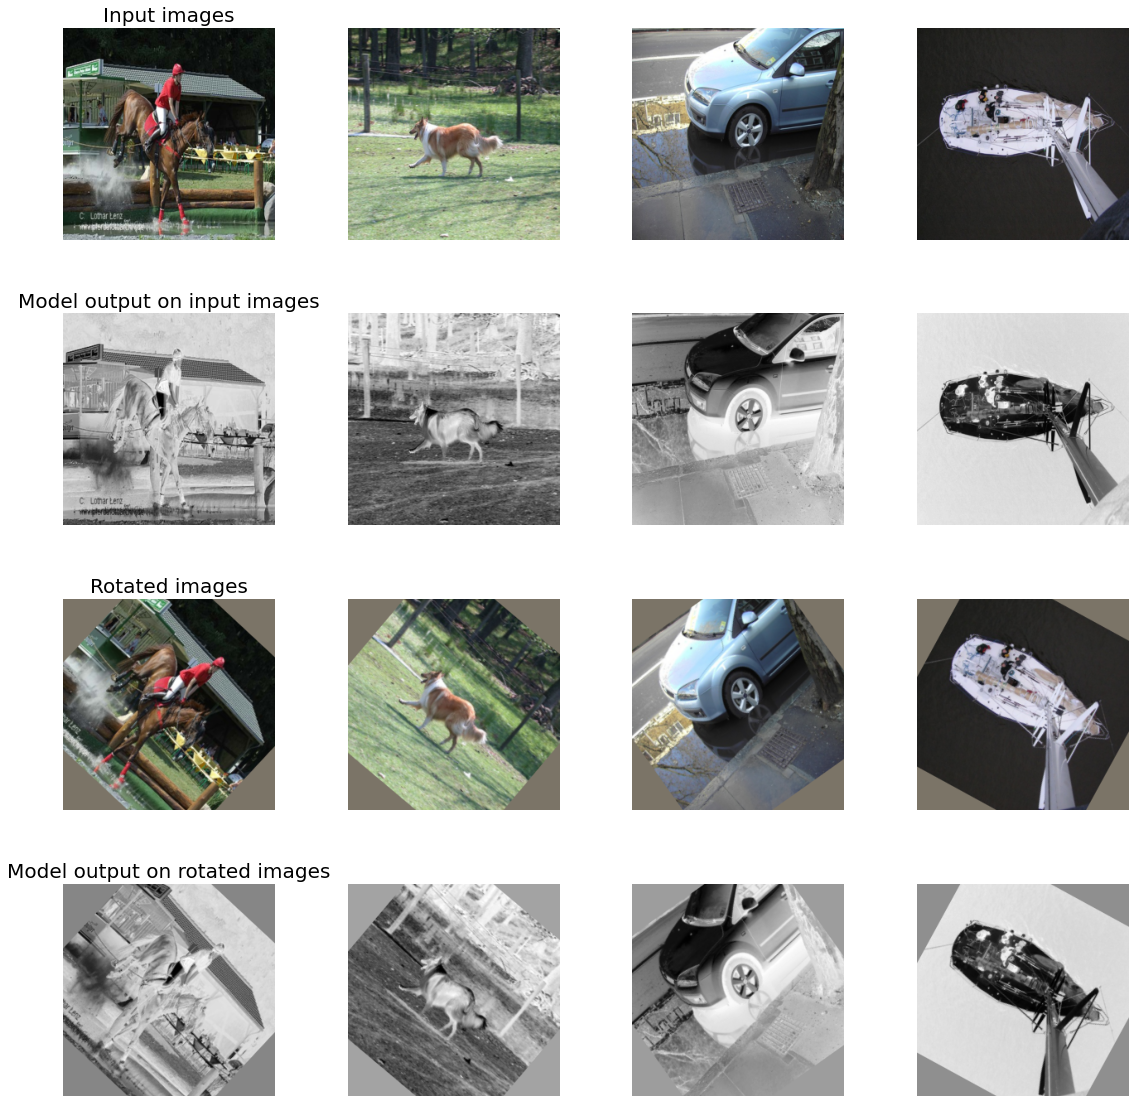

In [32]:
fig, ax = plt.subplots(nrows=4, ncols=4, figsize=(16, 16))

# Convert tensors to numpy, transpose channels and reverse normalization for display purposes
x_display = unnormalize(x).numpy().transpose(0, 2, 3, 1)
tx_display = unnormalize(tx).numpy().transpose(0, 2, 3, 1)
fx_display = fx.squeeze().detach().cpu().numpy()
ftx_display = ftx.squeeze().detach().cpu().numpy()

for i in range(4):
    ax[0, i].imshow(x_display[i])
    ax[0, i].axis('off')
    
    ax[1, i].imshow(fx_display[i], cmap='gray')
    ax[1, i].axis('off')
    
    ax[2, i].imshow(tx_display[i])
    ax[2, i].axis('off')
    
    ax[3, i].imshow(ftx_display[i], cmap='gray')
    ax[3, i].axis('off')
    
ax[0, 0].set_title('Input images', fontsize=20)
ax[1, 0].set_title('Model output on input images', fontsize=20)
ax[2, 0].set_title('Rotated images', fontsize=20)
ax[3, 0].set_title('Model output on rotated images', fontsize=20)
plt.tight_layout()

As we see the loss is zero and the output of the model changes consistently when the input changes.

# Example 3: Real data on pre-trained segmentation model

Data has been loaded in the previous example.
We only need to download pre-trained segmentation model from torchvision library.

In [34]:
# Load model
import torchvision
model = torchvision.models.segmentation.fcn_resnet50(
    pretrained=True, progress=True, num_classes=21, aux_loss=None
)
model.to(device)

FCN(
  (backbone): IntermediateLayerGetter(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequenti

In [35]:
data_batch = next(data_loader_iter)
x = data_batch[0]

In [36]:
# Compute TfEquivarianceLoss on one batch (ground truth is not used)

# Generate a transformation
tf_equiv_loss.set_tf_matrices()

# Compute model on input image
fx = model(x)['out']

# Transform output
tfx = tf_equiv_loss.transform(fx)

# Transform input image
tx = tf_equiv_loss.transform(x)

# Compute model on the transformed image
ftx = model(tx)['out']

loss = tf_equiv_loss(tfx, ftx)
loss

tensor(4.0971, grad_fn=<MseLossBackward>)

In [37]:
# Define the helper function
def decode_segmap(image, nc=21):
    label_colors = np.array([(0, 0, 0),  # 0=background
               # 1=aeroplane, 2=bicycle, 3=bird, 4=boat, 5=bottle
               (128, 0, 0), (0, 128, 0), (128, 128, 0), (0, 0, 128), (128, 0, 128),
               # 6=bus, 7=car, 8=cat, 9=chair, 10=cow
               (0, 128, 128), (128, 128, 128), (64, 0, 0), (192, 0, 0), (64, 128, 0),
               # 11=dining table, 12=dog, 13=horse, 14=motorbike, 15=person
               (192, 128, 0), (64, 0, 128), (192, 0, 128), (64, 128, 128), (192, 128, 128),
               # 16=potted plant, 17=sheep, 18=sofa, 19=train, 20=tv/monitor
               (0, 64, 0), (128, 64, 0), (0, 192, 0), (128, 192, 0), (0, 64, 128)])

    r = np.zeros_like(image).astype(np.uint8)
    g = np.zeros_like(image).astype(np.uint8)
    b = np.zeros_like(image).astype(np.uint8)
  
    for l in range(0, nc):
        idx = image == l
        r[idx] = label_colors[l, 0]
        g[idx] = label_colors[l, 1]
        b[idx] = label_colors[l, 2]
    
    rgb = np.stack([r, g, b], axis=2)
    return rgb

In [38]:
import numpy as np

Segmentation model inputs 21 channels for each image (one segmentation map for each class and one background map).
We use helper function to decode segmentation maps. Source of the function https://learnopencv.com/pytorch-for-beginners-semantic-segmentation-using-torchvision/

WARNING - Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


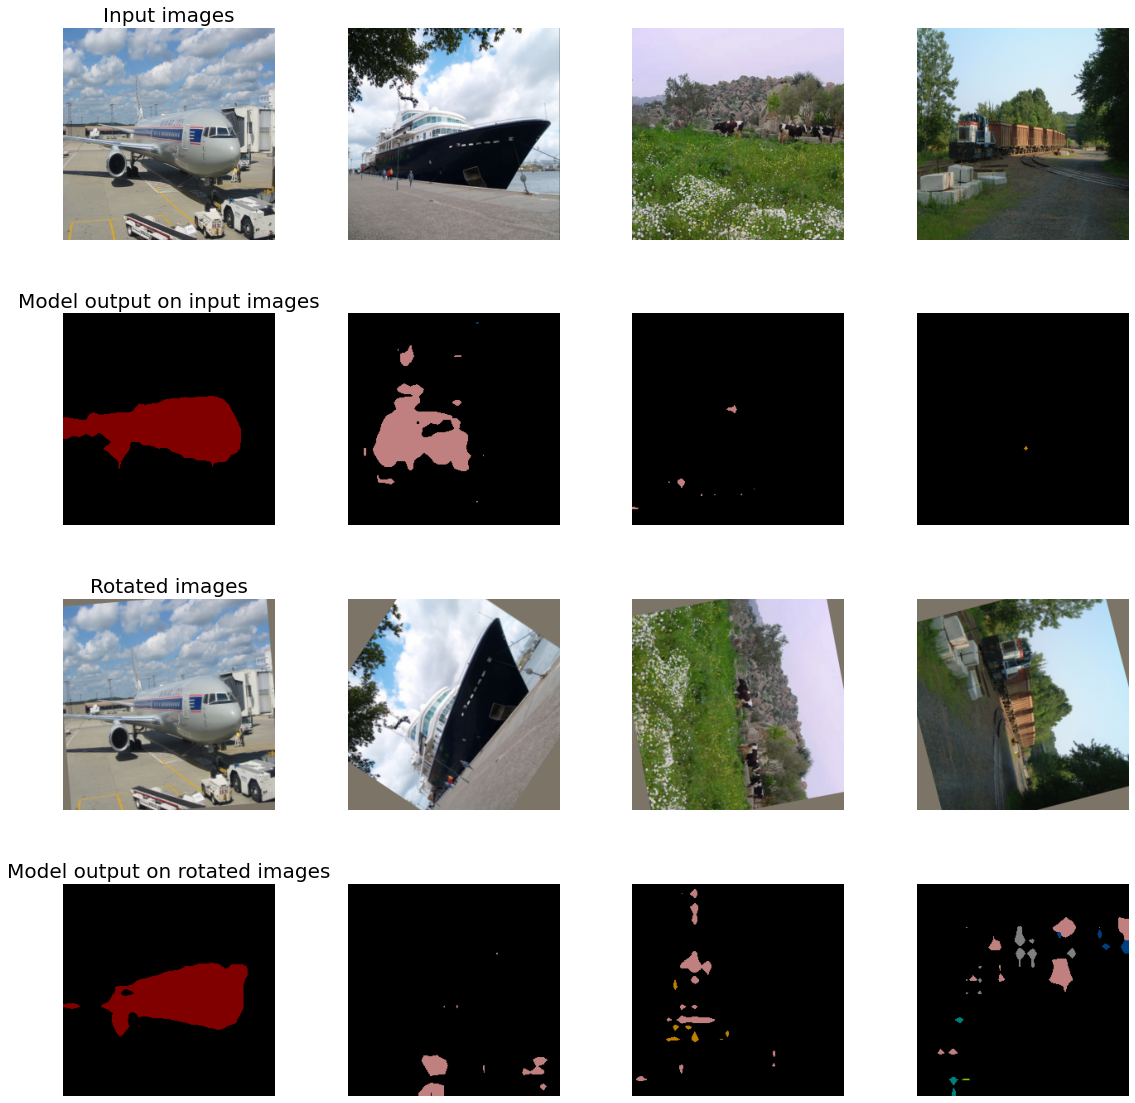

In [39]:
fig, ax = plt.subplots(nrows=4, ncols=4, figsize=(16, 16))

# Convert tensors to numpy, transpose channels and reverse normalization for display purposes
x_display = unnormalize(x).numpy().transpose(0, 2, 3, 1)
tx_display = unnormalize(tx).numpy().transpose(0, 2, 3, 1)
# fx_display = fx.squeeze().detach().cpu().numpy()
fx_display = torch.argmax(fx.squeeze(), dim=1).detach().cpu().numpy()
# ftx_display = ftx.squeeze().detach().cpu().numpy()
ftx_display = torch.argmax(ftx.squeeze(), dim=1).detach().cpu().numpy()

# Output class indices f

for i in range(4):
    ax[0, i].imshow(x_display[i])
    ax[0, i].axis('off')
    
    ax[1, i].imshow(decode_segmap(fx_display[i]), cmap='gray')
    ax[1, i].axis('off')
    
    ax[2, i].imshow(tx_display[i])
    ax[2, i].axis('off')
    
    ax[3, i].imshow(decode_segmap(ftx_display[i]), cmap='gray')
    ax[3, i].axis('off')
    
ax[0, 0].set_title('Input images', fontsize=20)
ax[1, 0].set_title('Model output on input images', fontsize=20)
ax[2, 0].set_title('Rotated images', fontsize=20)
ax[3, 0].set_title('Model output on rotated images', fontsize=20)
plt.tight_layout()